In [15]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error
path = "Results/taxi/taxi_ip_336_op_50_predict_50/taxi/"
preds = np.load(path+'trans-huber-ar_pred_mu.npy')
inputs = np.load(path+'inputs.npy')
trues = np.load(path+'targets.npy')
#preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
#trues = trues.reshape(-1, preds.shape[-2], preds.shape[-1])
# [samples, pred_len, dimensions]
print(preds.shape, trues.shape, inputs.shape)

print("mse : ",mean_squared_error(trues.squeeze(),preds.squeeze()),"mae: ",mean_absolute_error(trues.squeeze(),preds.squeeze()))

(192, 50, 1) (192, 50, 1) (192, 336, 1)
mse :  6916272.0 mae:  1715.3097


In [34]:
# x = preds.reshape(54,13,-1,1)
# preds = x.mean(axis=1)
# preds.shape
# x = trues.reshape(54,13,-1,1)
# trues = x.mean(axis=1)
# trues.shape

# print("mse : ",mean_squared_error(trues.squeeze(),preds.squeeze()),"mae: ",mean_absolute_error(trues.squeeze(),preds.squeeze()))

/tmp/ipykernel_52650/522957238.py:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



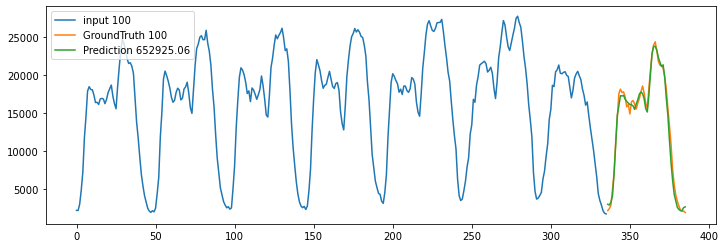

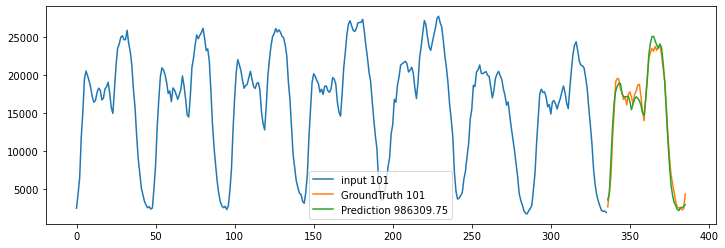

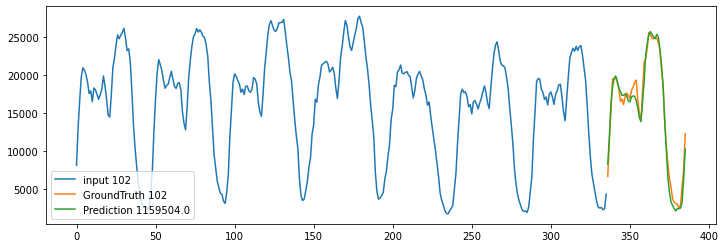

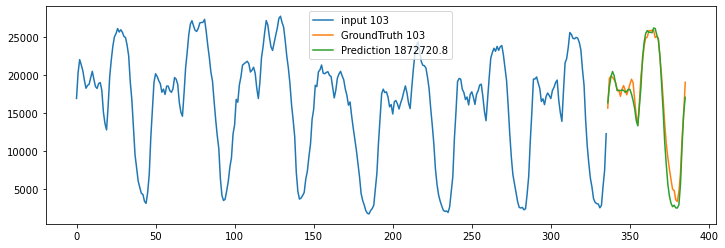

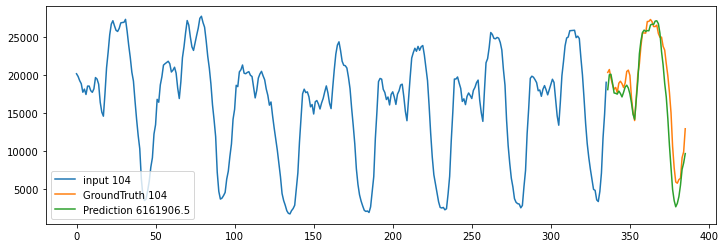

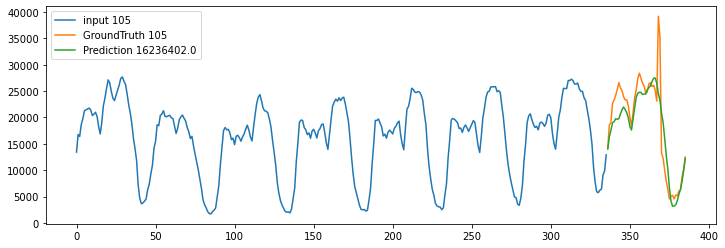

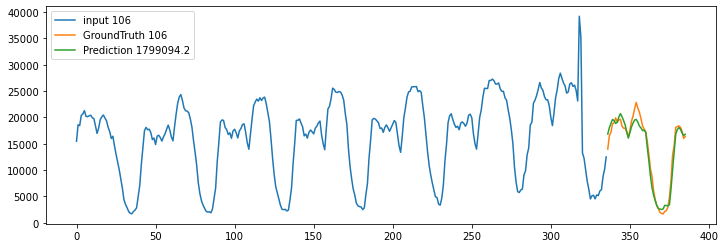

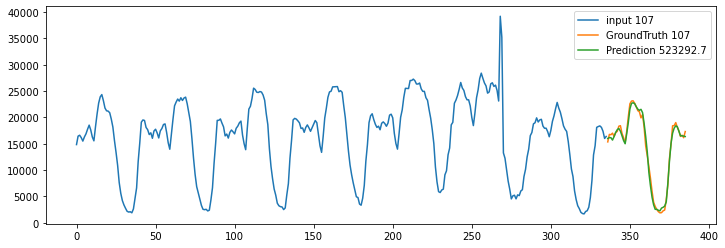

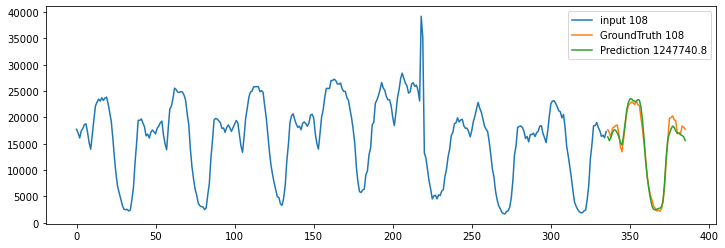

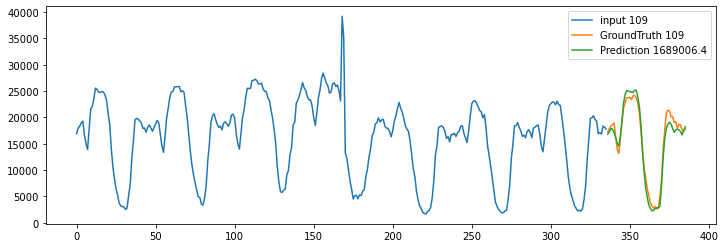

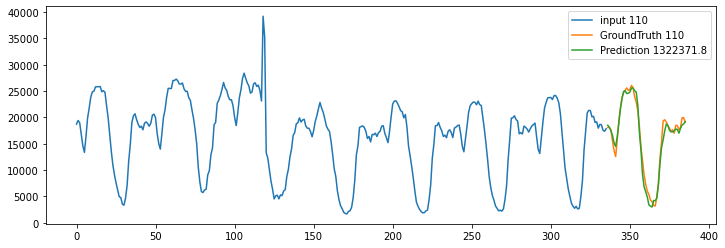

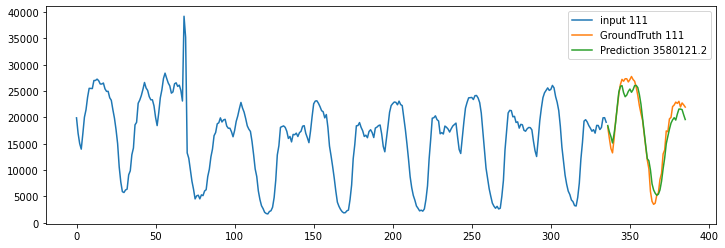

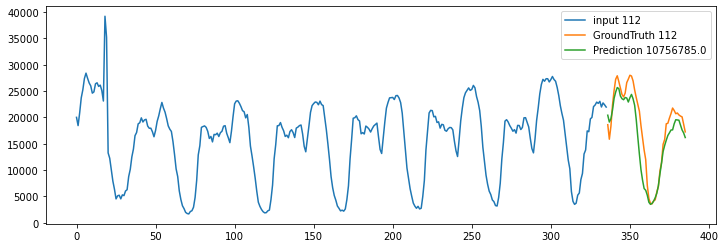

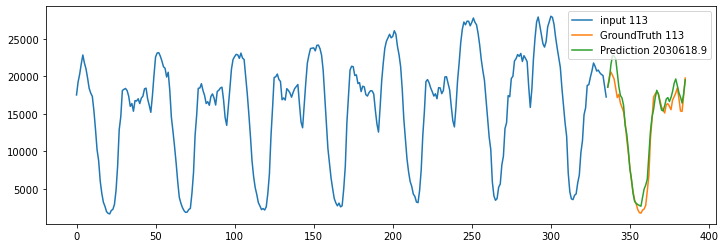

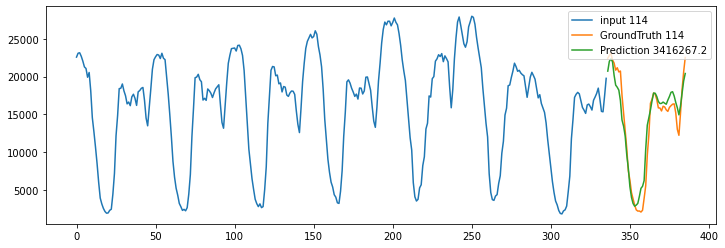

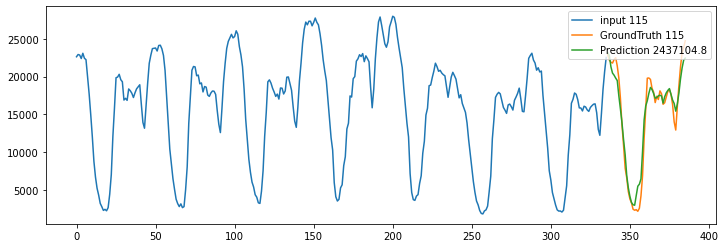

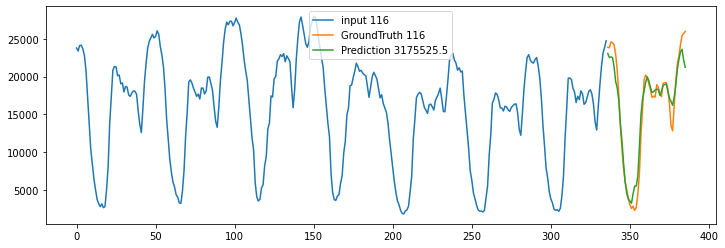

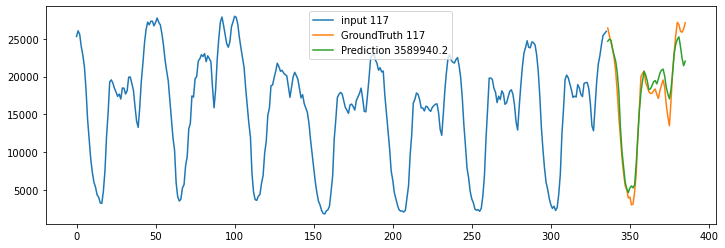

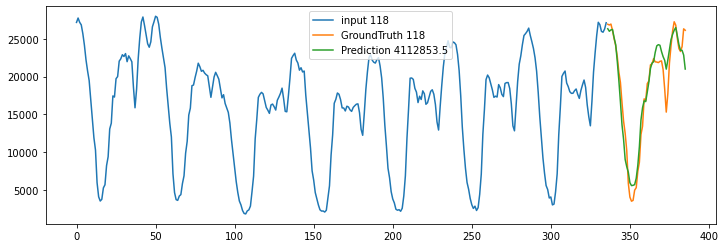

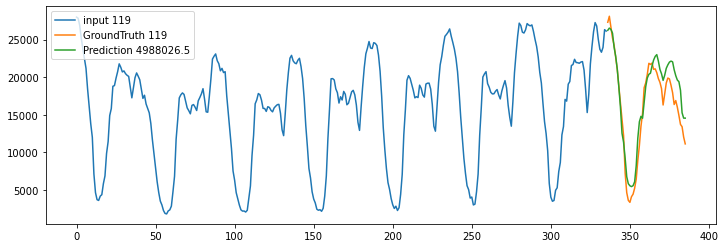

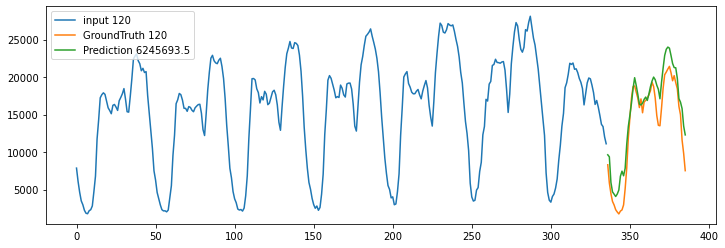

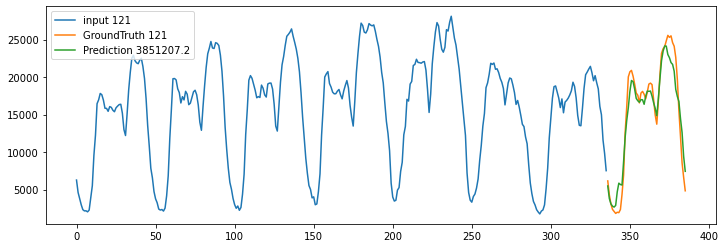

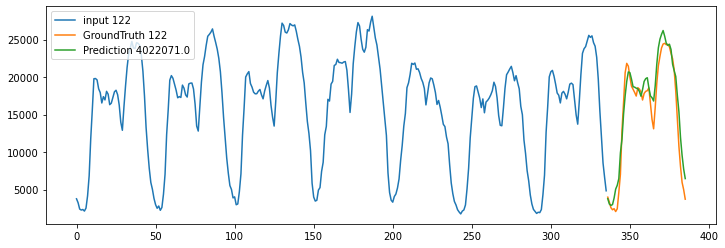

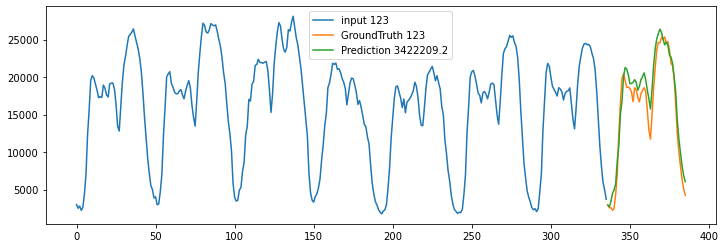

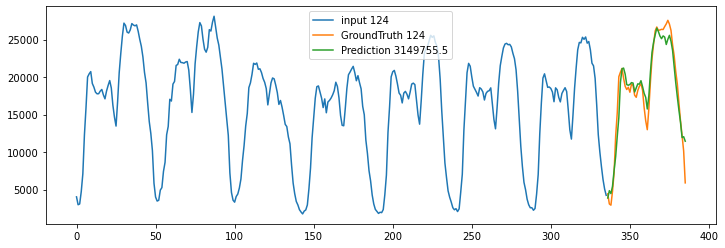

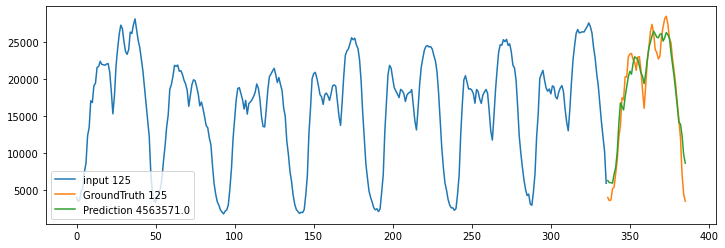

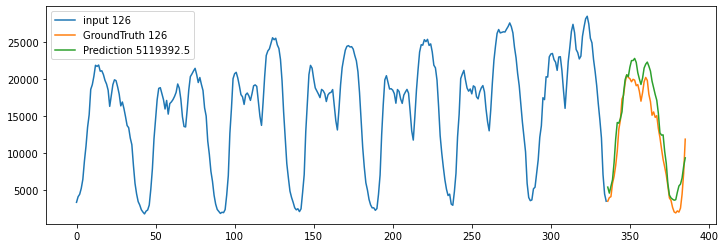

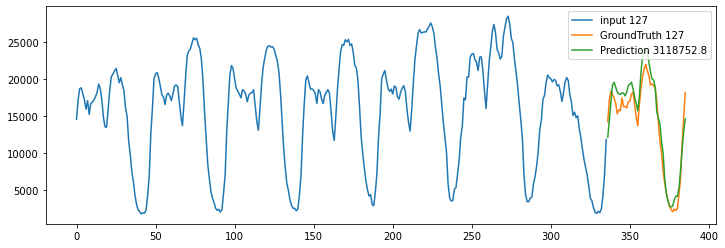

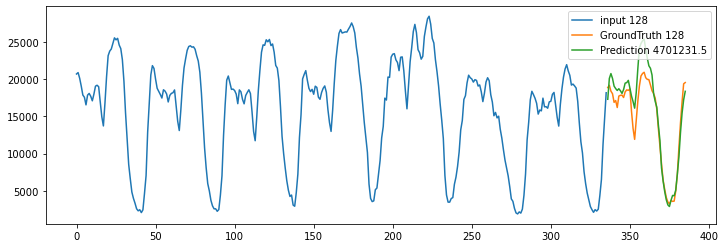

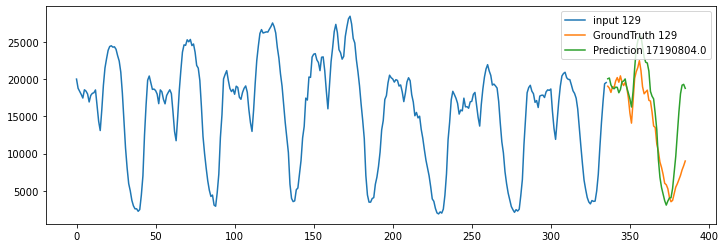

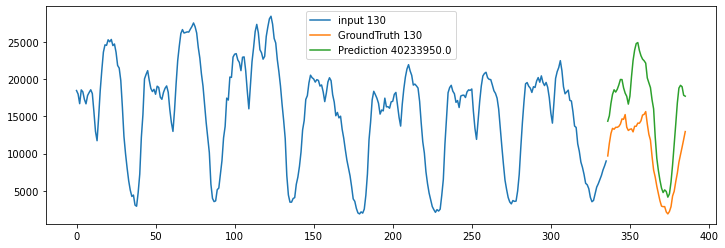

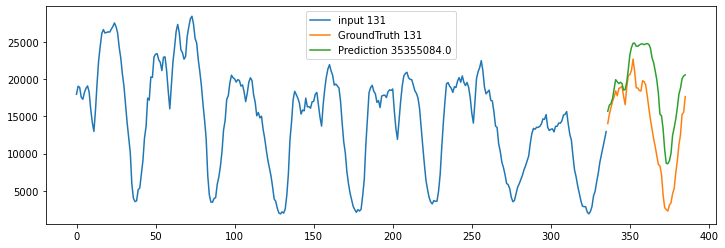

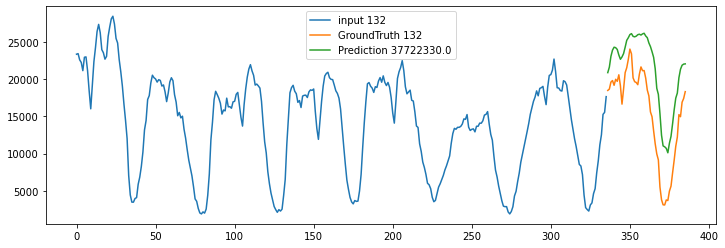

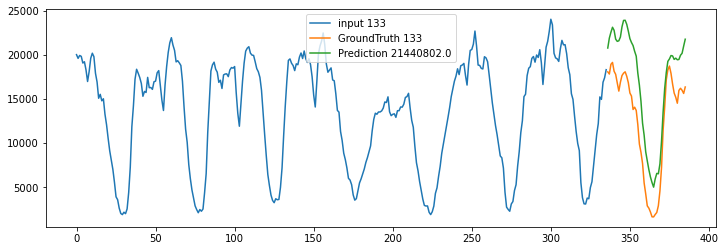

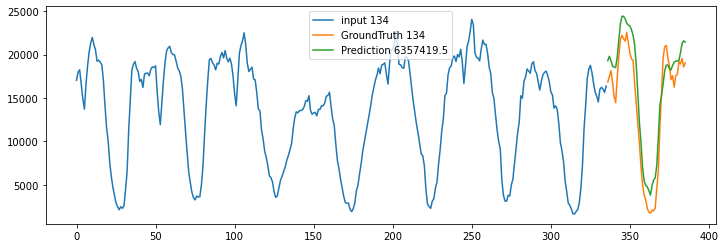

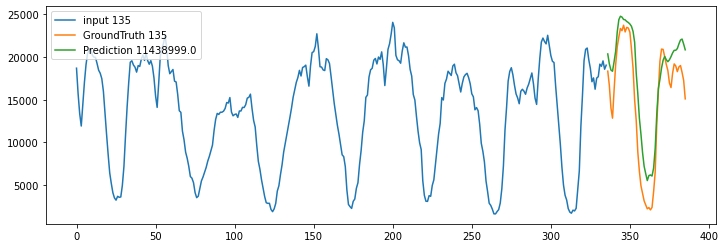

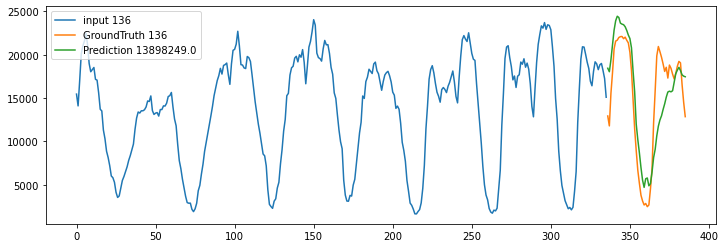

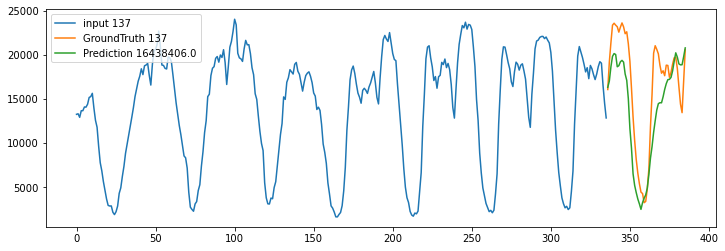

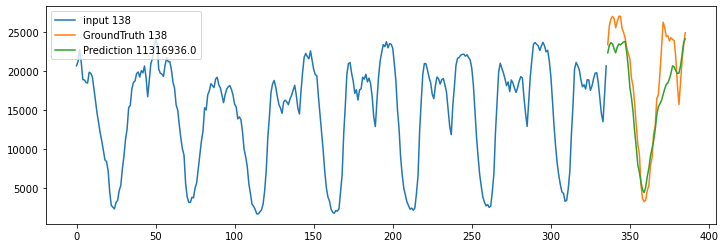

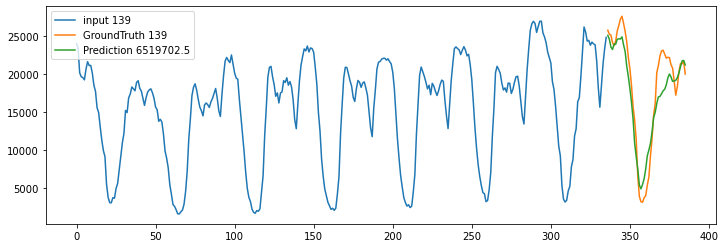

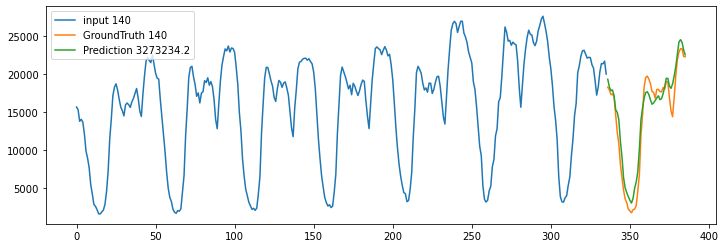

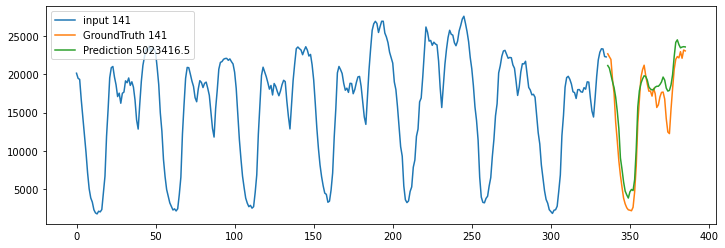

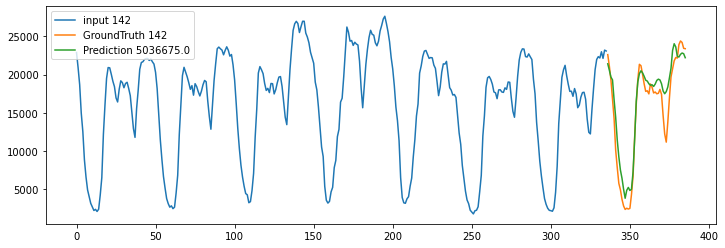

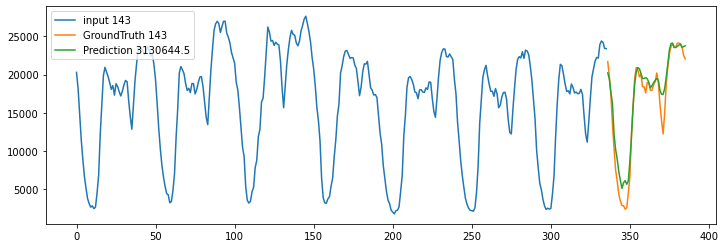

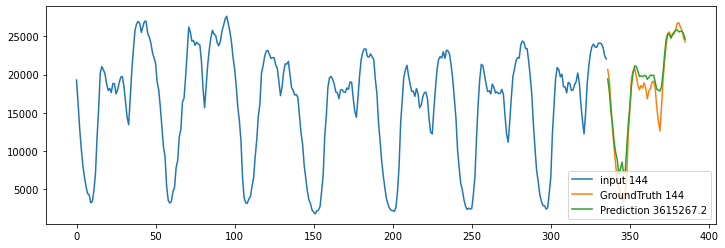

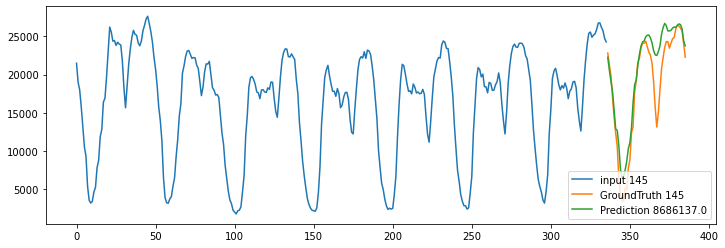

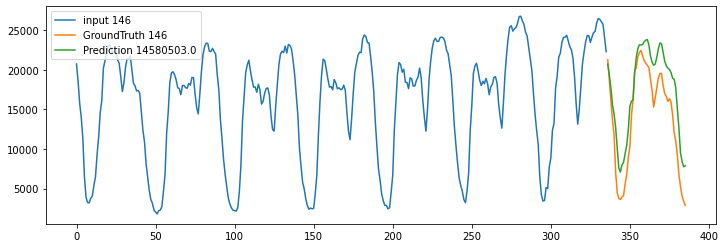

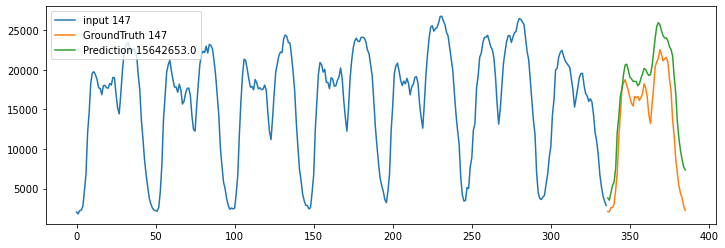

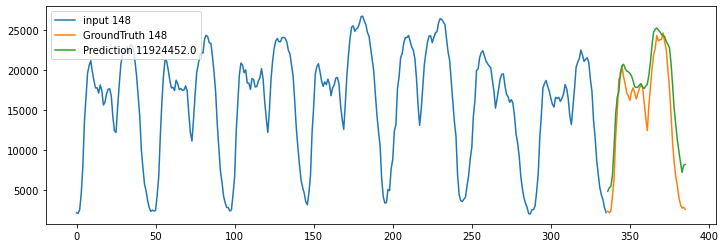

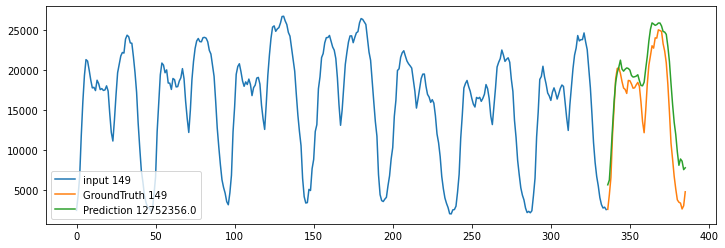

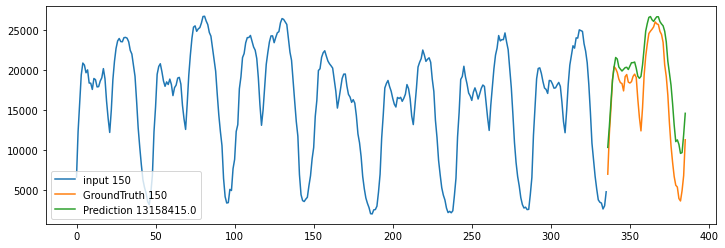

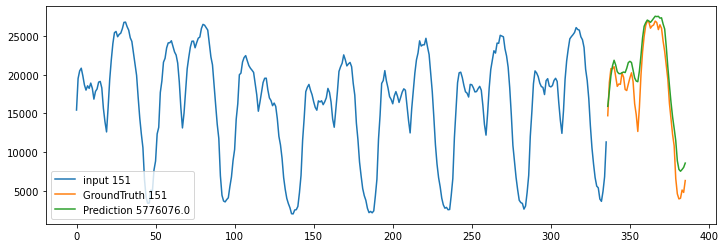

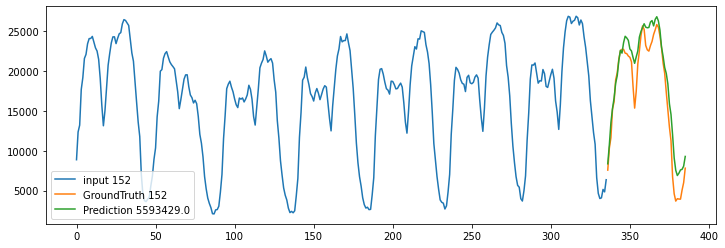

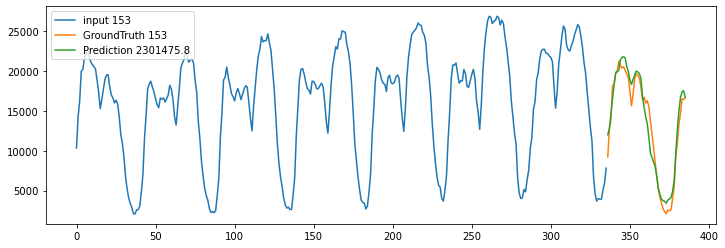

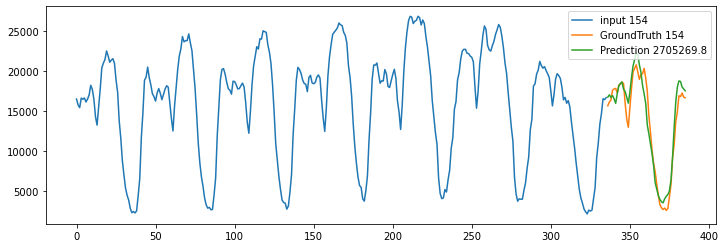

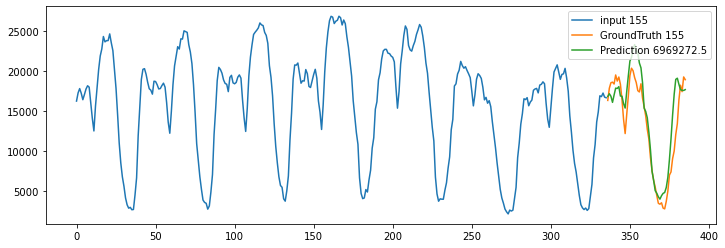

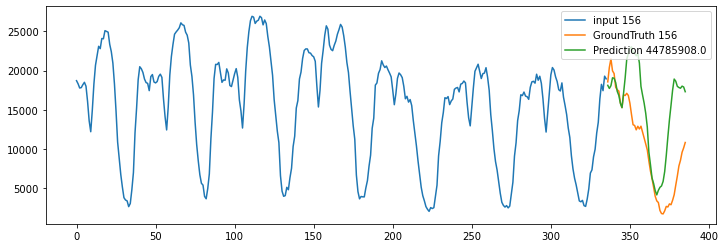

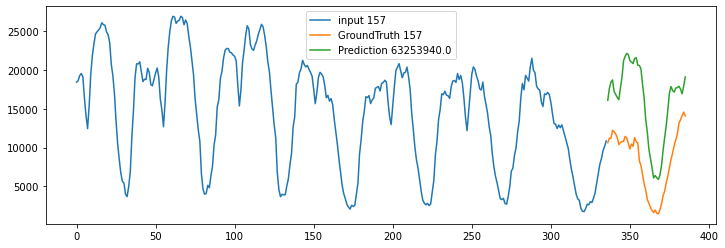

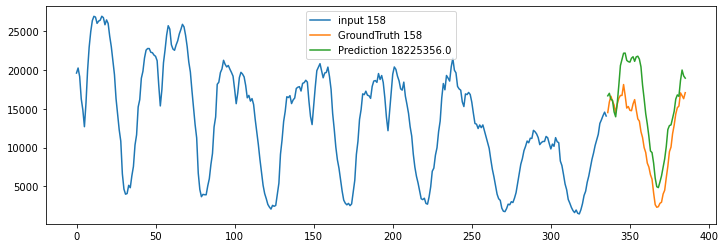

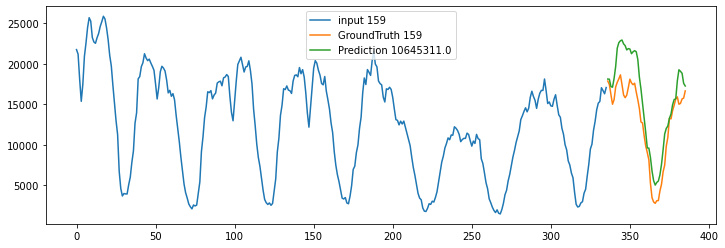

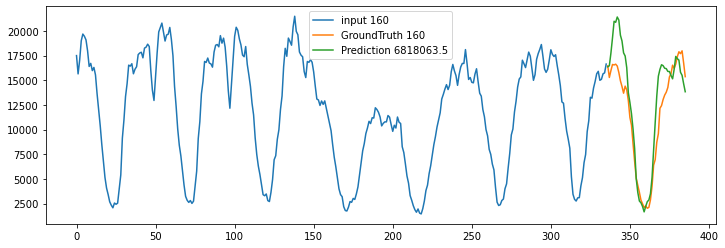

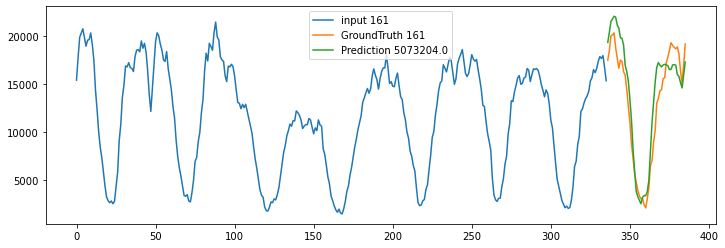

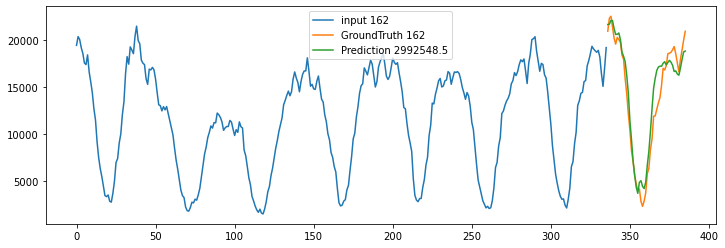

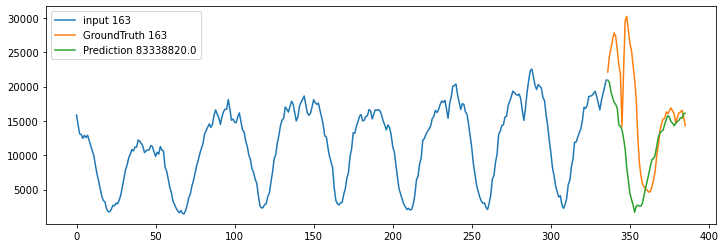

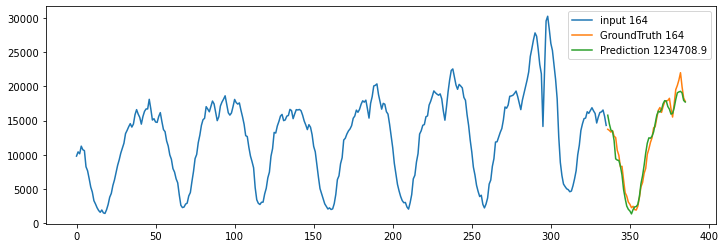

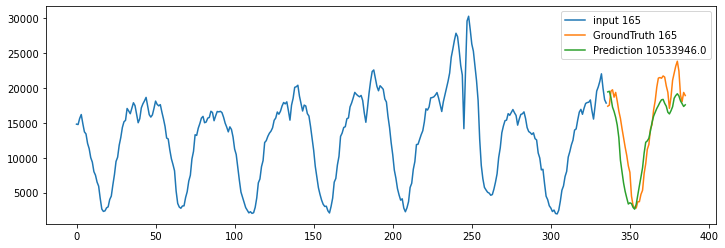

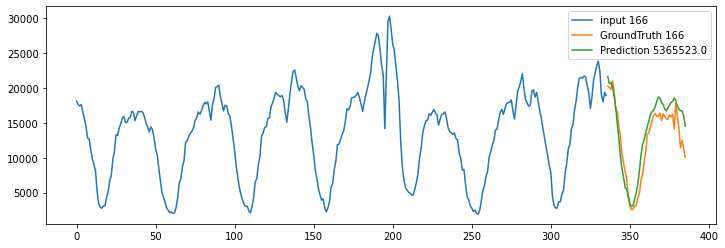

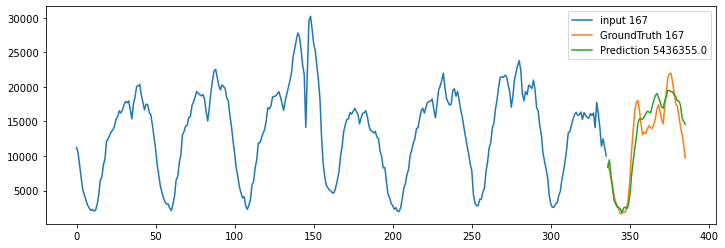

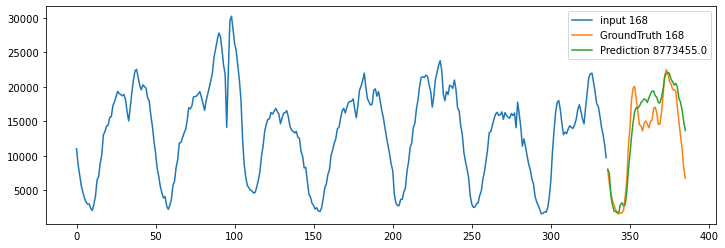

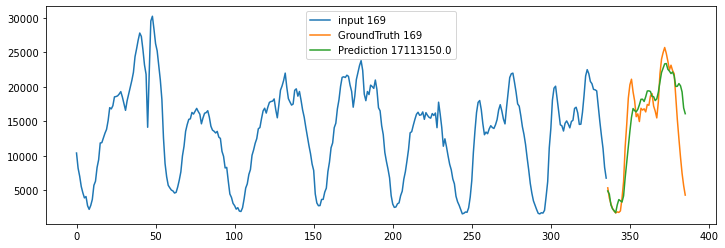

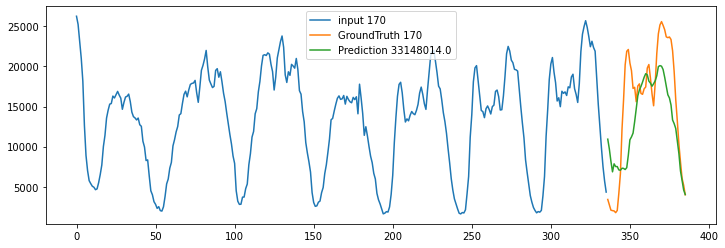

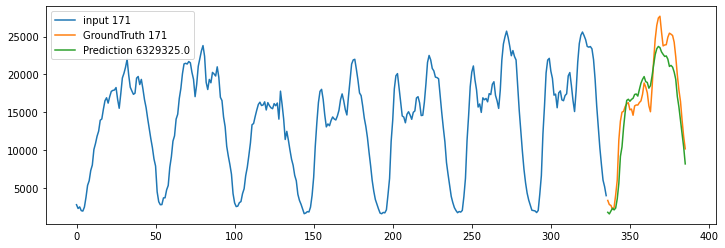

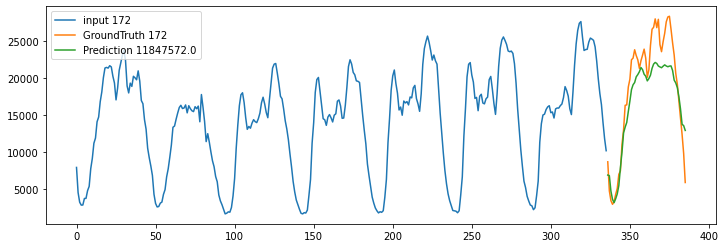

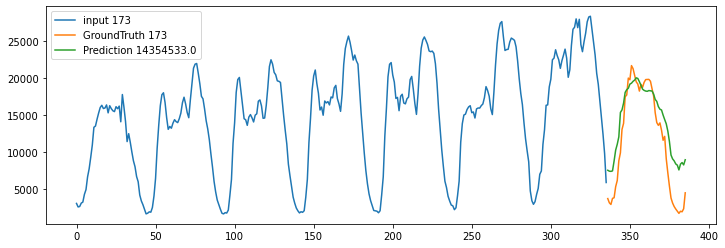

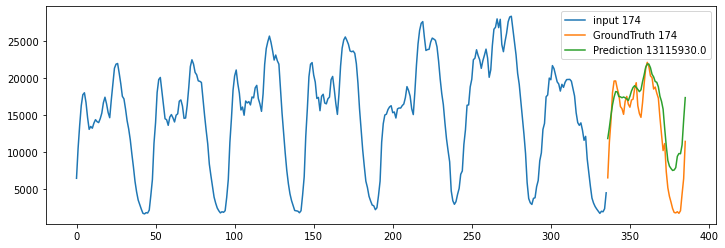

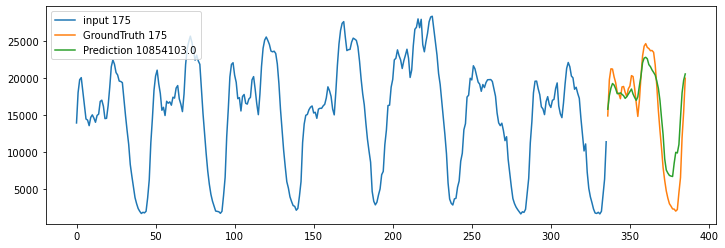

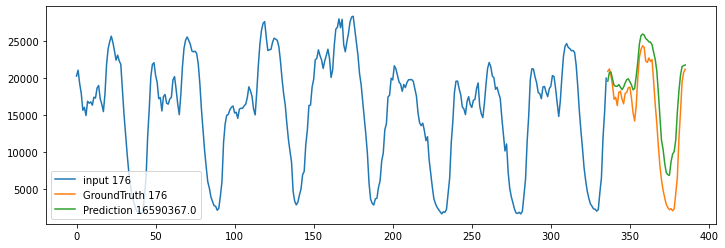

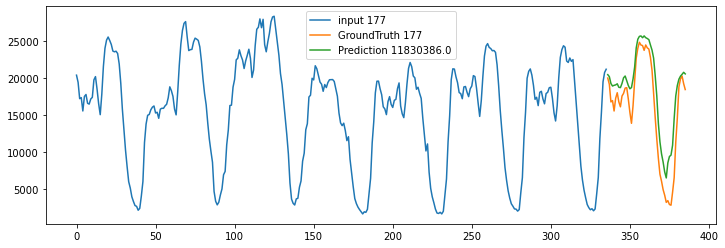

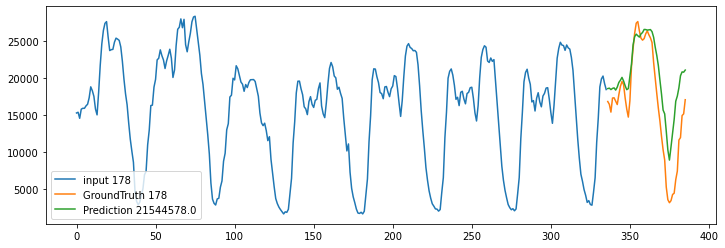

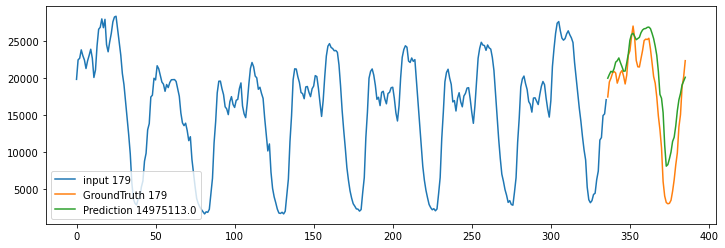

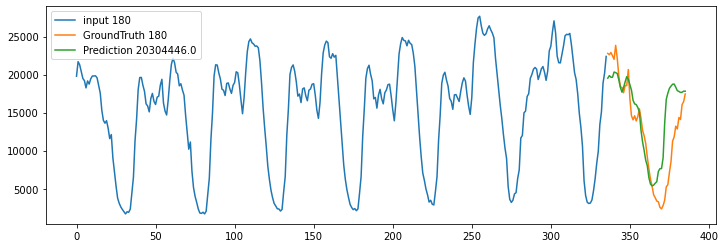

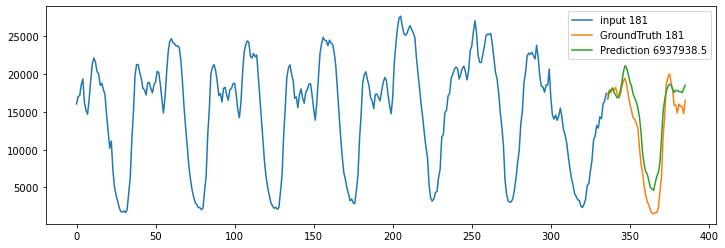

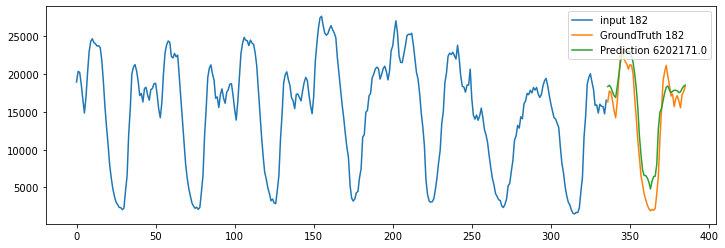

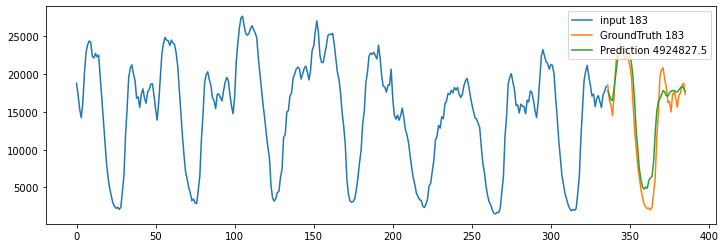

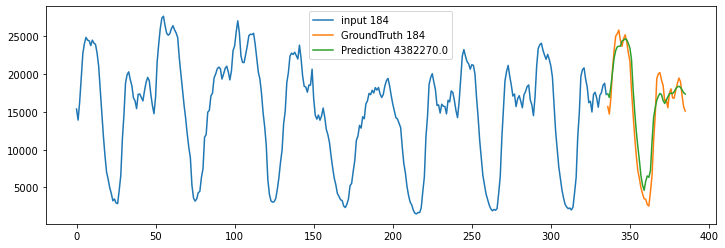

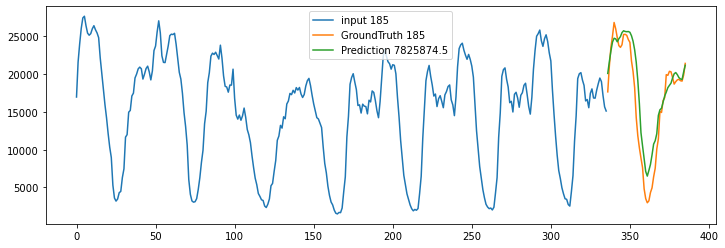

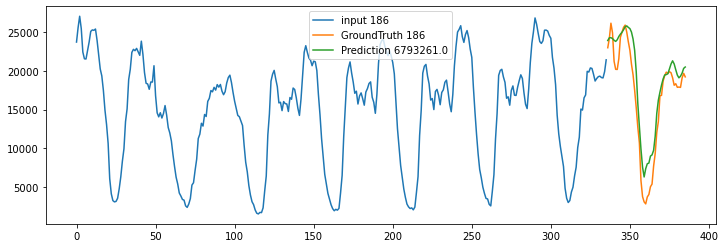

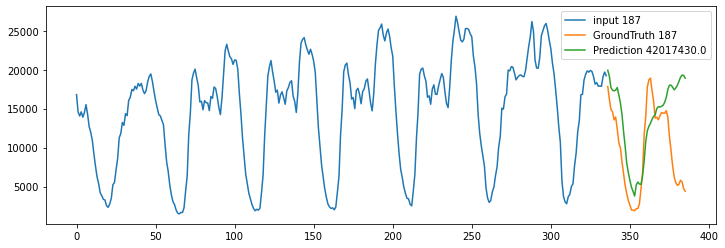

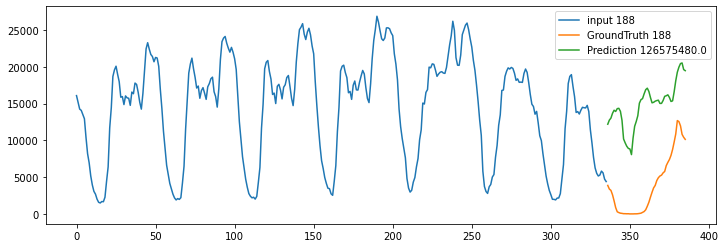

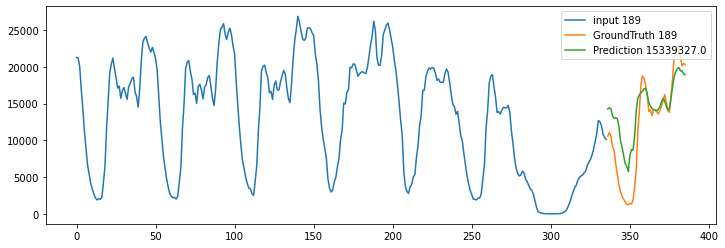

In [18]:
plt.rcParams['figure.figsize'] = (12,4)
x = np.arange(inputs.shape[1]+preds.shape[1])
a = inputs.shape[1]

for i in range(100,190):
    plt.figure()
    c =i 
    plt.plot(x[:a],inputs[c],label='input '+str(c))
    plt.plot(x[a:],trues[c,:,0], label='GroundTruth '+str(c))
    #for i in range(1):

    plt.plot(x[a:],preds[c,:,0], label='Prediction '+str(mean_squared_error(preds[c,:,0],trues[c,:,0])))
    
    plt.legend()
    # fig = plt.figure()
    # plt.savefig("images/trans-mse_test_"+str(i)+".png")
    
    # plt.show()

In [20]:
!python mask_generator.py --dataset_name taxi

Results/taxi/taxi_ip_336_op_100_predict_100/taxi
336 inp.shape
(96, 100) (96, 100) 96 96 16
Best Threshold: 0.16326400637626648 with G-Mean: 0.835056
FPR: 0.103448, TPR: 0.777778
Results/taxi/taxi_ip_336_op_50_predict_50/taxi
336 inp.shape
(192, 50) (192, 50) 192 192 32
Best Threshold: 0.04544899985194206 with G-Mean: 0.823387
FPR: 0.152542, TPR: 0.8
(9600,) (9600,)
(9600,)
File saved as /mnt/a99/d0/sandy/Forecasting/data/taxi/taxi_mask_roc.npy !!
taxi_mask_roc.npy                             100%   38KB  23.1MB/s   00:00    
File saved as sandy@cat.cse.iitb.ac.in:/mnt/cat/data/sandy/Forecasting/data/taxi/taxi_mask_roc.npy !!


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn import metrics, datasets
DATA_DIRS = "/mnt/a99/d0/sandy/Forecasting/"
df = pd.read_csv(
    os.path.join(DATA_DIRS, 'data', 'electricity_load_forecasting_panama', '2_percent_electricity.csv')
)
data = df[['nat_demand']].to_numpy().T
labels =  df[['label']].to_numpy()

path = "Results/electricity_train_m/electricity_ip_100_op_50_test_01/electricity/"
preds = np.load(path+'trans-mse-ar_pred_mu.npy')
inputs = np.load(path+'inputs.npy')
trues = np.load(path+'targets.npy')
new_preds = preds.squeeze()
new_trues = trues.squeeze()
N_input = 336
# print(new_preds.shape,new_trues.shape)
n = (N_input-1)//50 + 1
(l,h) = new_preds.shape
final = []
for line in range(0,l,n-1):
    chunk = dict()
    chunk['preds'] = new_preds[line:line+n]
    chunk['trues'] = new_trues[line:line+n]
    chunk['mask'] = np.zeros_like(new_trues[line:line+n])
    chunk['mse'] = [(mean_squared_error(i,j)-minmse)/(maxmse-minmse) for i,j in zip(new_preds[line:line+n],new_trues[line:line+n])]
    final.append(chunk)
mse = [mean_squared_error(i,j) for i,j in zip(new_preds,new_trues)]

minmse = min(mse)
maxmse = max(mse)
mse_norm = [(m-minmse)/(maxmse-minmse) for m in mse]


labels = labels[200:200+l*h].reshape(-1,h)


last = 3
if h==25:
    last = 3

label = [1 if sum(line)>5 else 0 for line in labels]

fpr, tpr, thresholds = roc_curve(label, mse_norm)
score = metrics.auc(fpr, tpr)
print(labels.shape,new_preds.shape,len(label),len(mse))
print(thresholds)
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))
# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 6)
gmeanOpt = round(gmean[index], ndigits = 6)
fprOpt = round(fpr[index], ndigits = 6)
tprOpt = round(tpr[index], ndigits = 6)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

pred_labels = [1 if i>thresholdOpt else 0 for i in mse_norm ]

plt.plot(fpr,tpr)
plt.plot(fprOpt,tprOpt,marker="o")
plt.show()

# plt.plot(label)
plt.plot(np.array(label)-np.array(pred_labels))
plt.show()
final_mask = []
for i in pred_labels:
    temp = np.zeros((h))
    temp = temp + i
    # print(temp.shape)
    final_mask.extend(temp)
final_mask = np.array(final_mask)
for j,line in enumerate(final):
    # print(sorted(line['mse'],reverse=True))
    # msep = np.quantile(mse,0.75)+iqr(mse,interpolation='midpoint')*1.5
    for x in range(1,last):
        if len(line['mse'])<2:
            continue
        i = np.argsort(line['mse'])[-x]
        if line['mse'][i]>thresholdOpt:
            final[j]['mask'][i]= 1
mask = final[0]['mask'].flatten()
for line in final[1:]:
    mask=np.hstack((mask,line['mask'][1:].flatten()))


np.save("mask_electricity_100_op_50_1.npy",mask)

In [7]:
# print(len(mask))



In [133]:
mask1 = np.load("mask_electricity_100_op_25.npy")
mask2 = np.load("mask_electricity_100_op_50.npy")
mask3 = np.load("mask_electricity_100_op_25_1.npy")
mask4 = np.load("mask_electricity_100_op_50_1.npy")
m = trues.reshape(-1,)
print(mask1.shape,mask2.shape,m.shape)
# print(sum(mask)/len(mask))
# data_mask = mask1[25:-25]*mask2
length = min(len(mask1),len(mask2))
print(length)
mask1 = mask1[:length]
mask2 = mask2[:length]
mask3 = mask3[:length]
mask4 = mask4[:length]


(45475,) (45450,) (45450,)
45450


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(y= m,name='input'))
fig.add_trace(
    go.Scatter(y = mask1*500,name='mask25'))

fig.add_trace(
    go.Scatter(y = mask2*600,name='mask50'))
fig.add_trace(
    go.Scatter(y = mask3*700,name='mask25__1'))

fig.add_trace(
    go.Scatter(y = mask4*800,name='mask50__1'))



fig.show()


code for imputation for energy data

In [39]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn import metrics, datasets
plt.rcParams['figure.figsize']=(25,5)
DATA_DIRS = "/mnt/a99/d0/sandy/Forecasting/"
df = pd.read_csv(DATA_DIRS+'data/energy-anomaly-detection/energy_injected_reduced.csv')
data = df[['meter_reading']].to_numpy()
labels = df[['anomaly']].to_numpy()
# print(sum(labels))
path = "Results/energy_train_m/energy_ip_200_op_25_for_forecasting/energy/"
preds = np.load(path+'trans-mse-ar_pred_mu.npy')
inputs = np.load(path+'inputs.npy')
trues = np.load(path+'targets.npy')
cb = inputs.shape[1]
print(cb,"input length")
preds = preds.reshape(-1,)
trues = trues.reshape(-1,)

# print(preds.shape,inputs.shape,trues.shape)
cwd = "/mnt/a99/d0/sandy/Forecasting/data/"
save_path=os.path.join(cwd,"energy",f"energy_mask_roc_{cb}.npy")
mask_values = np.load(save_path)
# print(mask_values.shape,data.shape,labels.shape)
# for i,x in enumerate(mask_values):
#     if x==1:
#         data[i+2*cb]=preds[i]
#         labels[i+2*cb]=1
#         # print(data[i+200])
# df[['nat_demand']] = data
# df[['label']] = labels

200 input length


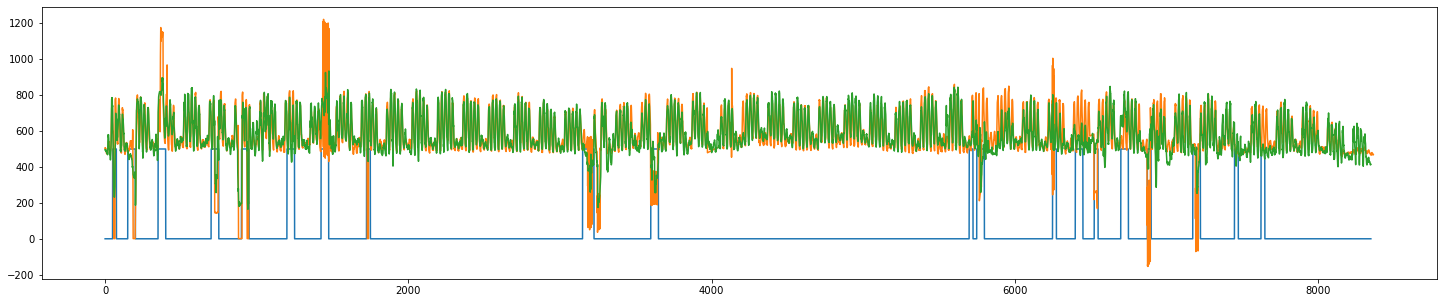

In [23]:
plt.plot(mask_values*500)
plt.plot(data[400:])
plt.plot(preds)
plt.show()

In [ ]:
px.line(data[400:])

In [ ]:
px.line(data[400:])


In [4]:
import subprocess
file_p =  os.path.join(cwd, 'energy', f'energy_imputation_roc_{cb}.csv')
file_ssh =  os.path.join("/mnt/cat/data/sandy/Forecasting", 'data', 'energy', f'electricity_imputation_roc_{cb}.csv')
df.to_csv(file_p)
subprocess.run(["scp",file_p, f"sandy@cat.cse.iitb.ac.in:{file_ssh}"])




CompletedProcess(args=['scp', '/mnt/a99/d0/sandy/Forecasting/data/energy/energy_imputation_roc_200.csv', 'sandy@cat.cse.iitb.ac.in:/mnt/cat/data/sandy/Forecasting/data/energy/electricity_imputation_roc_200.csv'], returncode=0)

In [13]:
path = "/mnt/a99/d0/sandy/Forecasting/data/energy/energy_imputation_roc_200.csv"
import plotly.express as px 
dataset = pd.read_csv(path)
dataset['meter_reading']=dataset['nat_demand']
dataset['anomaly']=dataset['label']
dataset = dataset[['timestamp','meter_reading','anomaly']]
dataset.head()

timestamp  meter_reading  anomaly
0  2016-01-01 00:00:00          488.0        0
1  2016-01-01 01:00:00          488.0        0
2  2016-01-01 02:00:00          491.0        0
3  2016-01-01 03:00:00          490.0        0
4  2016-01-01 04:00:00          491.0        0

In [14]:
dataset.to_csv(path,index=None)
import subprocess
cb = 200
# file_p =  os.path.join(cwd, 'energy', f'energy_imputation_roc_{cb}.csv')
file_ssh =  os.path.join("/mnt/cat/data/sandy/Forecasting", 'data', 'energy', f'electricity_imputation_roc_{cb}.csv')
# df.to_csv(file_p)
subprocess.run(["scp",path, f"sandy@cat.cse.iitb.ac.in:{file_ssh}"])

CompletedProcess(args=['scp', '/mnt/a99/d0/sandy/Forecasting/data/energy/energy_imputation_roc_200.csv', 'sandy@cat.cse.iitb.ac.in:/mnt/cat/data/sandy/Forecasting/data/energy/electricity_imputation_roc_200.csv'], returncode=0)

In [5]:
px.line(dataset.meter_reading)

In [9]:
px.line(dataset.meter_reading)